# Reflector imaging from ambient noise signals

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Position of the receivers, noise sources, and reflector.

In [2]:
# receivers
x = np.empty((5,3))
x[:, 1:] = [0, 100]
for j in range(5):
    x[j, 0] = -30 + 7.5*j

# reflector
z_r = np.array([65, 0, 65])
    
# noise sources
N = 200
y = np.random.uniform([-50, -10, 185], [50, 10, 200], (N,3))

Visualizing the position of receivers, reflector and noise sources.

Text(0, 0.5, 'x')

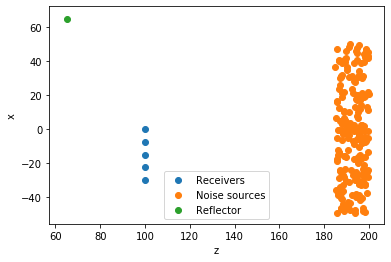

In [3]:
plt.scatter(x[:, 2], x[:, 0], label='Receivers')
plt.scatter(y[:, 2], y[:, 0], label='Noise sources')
plt.scatter(z_r[2], z_r[0], label='Reflector')
plt.legend()
plt.xlabel('z')
plt.ylabel('x')

Parameters of the Green function

In [4]:
# Born approximation parameters for Green's function
c_0 = 1
z_r = np.array([65, 0, 65])
sigma_r = 1e-3

Green functions: homogeneous solution and Born approximation

In [5]:
# Green functions
G_0_hat = lambda omega, x, y: np.exp(1j * omega / c_0 * np.linalg.norm(x - y)) / (4 * np.pi * np.linalg.norm(x - y))
G_hat = lambda omega, x, y: G_0_hat(omega, x, y) + sigma_r * omega**2 * G_0_hat(omega, x, z_r) * G_0_hat(omega, z_r, y)

Noise sources: stationary zero-mean Gaussain process

In [6]:
F_hat = lambda omega: np.exp(-omega**2)

## Question 1

The integral is estimated with a Riemann sum.

In [7]:
def riemann_sum(f, I):
    """
    Integral of f on interval I
    I is a linspace array
    """
    dx = I[1] - I[0]
    fx = [f(x) for x in I]
    return dx * np.sum(fx[:-1] + fx[1:]) / 2

f = lambda x: x
I = np.linspace(1, 2, 1e3)
riemann_sum(f, I)

1.5000000000001326

We use the equation (7) to express the empirical cross validation in the limit of $T >> 1$. The expression of the Green function is given by the Born approximation.

In [8]:
def C_N(tau, i, j, max_omega=5):
    sum = 0
    omega_array = np.linspace(-max_omega, max_omega, 100)
    for s in range(N):
        f = lambda omega: F_hat(omega) * np.conj(G_hat(omega, x[i], y[s])) * G_hat(omega, x[j], y[s]) * np.exp(-1j * omega * tau)
        sum += riemann_sum(f, omega_array)
    return np.real(sum / (2 * np.pi * N))

C_N(10, 4, 1)

2.7927967405069585e-08

We introduce a fast version for computing the empirical cross validation by precomputing all the values of the Green function.

In [9]:
def compute_green_hat(omega_array):
    green_hat = np.zeros((x.shape[0], y.shape[0], omega_array.shape[0]), dtype=complex)
    for i in range(x.shape[0]):
        for s in range(y.shape[0]):
            green_hat[i, s] = np.array([G_hat(omega, x[i], y[s]) for omega in omega_array], dtype=complex)
    return green_hat

omega_array = np.linspace(-10, 10, 200)
green_hat = compute_green_hat(omega_array)
green_hat.shape

(5, 200, 200)

In [10]:
def C_N_fast(tau, i, j, omega_array, green_hat):
    sum = 0
    F_hat_eitau_omega = np.array([F_hat(omega) * np.exp(-1j * omega * tau) for omega in omega_array])
    for s in range(N):
        f = F_hat_eitau_omega * np.conj(green_hat[i, s]) * green_hat[j, s]
        sum += np.trapz(f, omega_array)
    return np.real(sum / (2 * np.pi * N))

C_N_fast(10, 4, 1, omega_array, green_hat)

2.7927966223973795e-08

Compute empirical cross validation when $T >> 1$for several values of $\tau$.

In [11]:
tau_array = np.linspace(-200, 200, 100)
C_N_array = [C_N_fast(tau, 4, 1, omega_array, green_hat) for tau in tau_array]

Text(0, 0.5, '$C_N(\\omega, x_5, x_1)$')

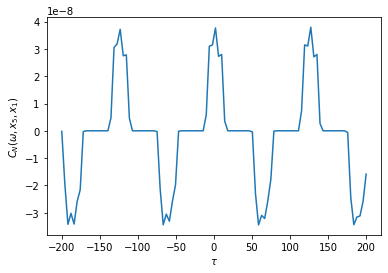

In [12]:
plt.plot(tau_array, C_N_array)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$C_N(\omega, x_5, x_1)$')

Plotting the KM image.

In [13]:
def I_N(y_S, omega_array, green_hat):
    sum = 0
    for j in range(x.shape[0]):
        for l in range(x.shape[0]):
            tau = np.linalg.norm(x[j] - y_S) + np.linalg.norm(y_S - x[l])
            sum += C_N_fast(tau, j, l, omega_array, green_hat)
    return sum

I_N(z_r, omega_array, green_hat)

-3.4346847496062257e-07

In [ ]:
res = 30
win_size = 20
tx = np.linspace(z_r[0] - win_size / 2, z_r[0] + win_size / 2, res)
tz = np.linspace(z_r[2] - win_size / 2, z_r[2] + win_size / 2, res)
image = np.array([[I_N([x, 0, z], omega_array, green_hat) for z in tz] for x in tx])

In [ ]:
plt.imshow(image, extent=[np.min(tz), np.max(tz), np.max(tx), np.min(tx)])
plt.colorbar()
plt.xlabel('z')
plt.ylabel('x')
plt.scatter(z_r[2], z_r[0], color='r', label='Reflector')
plt.legend(loc=3)